In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import scipy.sparse.csgraph
import sklearn.neighbors
from scipy.sparse import csr_matrix
import networkx as nx

import sys
# setting path
sys.path.append('../../')
import modules.find_patches_community_detection as find_patches

In [2]:
# set defaults for pytorch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(42)

In [4]:
# download dataset
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
dataset = datasets.MNIST(root='./torch-dataset', train=True,
                         download=True, transform=transform)

In [5]:
# load dataset into pytorch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=600000)
data,labels = next(iter(data_loader))
data = data.cuda()

torch.Size([5958, 1, 32, 32])


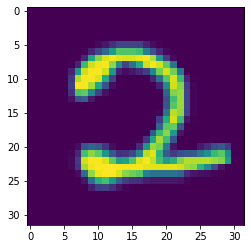

In [6]:
# select single class of dataset
Z = data[labels==2]
print(Z.shape)
# reshape array to (d x n) data matrix
Z = Z.reshape((5958,32**2))
Z = Z.T

d, n = Z.shape
# demonstrate data structure was preserved in reshape
plt.imshow(Z[:,3292].detach().cpu().numpy().reshape(32,32))

In [18]:
# index for proposed center
center_i = 20
# compute edm
EDM = torch.cdist(Z.T,Z.T)

EDM_i = EDM[center_i,:]
# sort edm
sorted_EDM_i, sorted_indices_i = torch.sort(EDM_i)

# compute sorted matrix of differences
Z_center = Z[:,[center_i]]
Z_diff = Z - Z_center
Z_diff = Z_diff[:,sorted_indices_i]

sing_val_sums = [1]
sing_vals_full = [1]
for j in range(2,n):
	Z_diff_slice = Z_diff[:,1:j]
	u, s, v = torch.svd(Z_diff_slice)
	sing_val_sums.append((s / s[0]).sum())
	sing_vals_full.append(s)
	if j % 100 == 0:
		print(f'step {j}')

plt.plot(sing_val_sums, '.')
plt.show()

step 100
step 200
step 300
step 400
step 500
step 600
step 700
step 800
step 900
step 1000
step 1100
step 1200
step 1300
step 1400
step 1500
step 1600
step 1700
step 1800
step 1900
step 2000
step 2100
step 2200
step 2300
step 2400
step 2500
step 2600
step 2700
step 2800
step 2900


KeyboardInterrupt: 

In [17]:
u, s, v = torch.svd(Z_diff)
s_mat = torch.diag(s)
print((u@s_mat@v[:1000,:].T - Z_diff[:,:1000]).pow(2).sum())

tensor(0.0050, device='cuda:0')


In [24]:
for i in range(1,len(sing_val_sums)):
	sing_val_sums[i] = sing_val_sums[i].cpu()

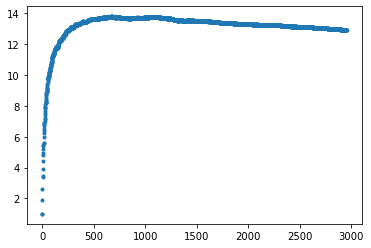

In [25]:
plt.plot(sing_val_sums, '.')
plt.show()

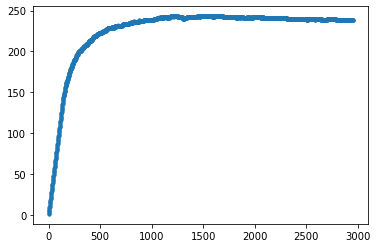

In [37]:
dim_counts = [1]
for i in range(1,len(sing_val_sums)):
	s_curr = sing_vals_full[i]
	s_0 = s_curr[0]
	dim_counts.append(s_curr[s_curr > s_0*0.01].shape[0])

plt.plot(dim_counts, '.')
plt.show()

In [7]:
Z_cpu = Z.cpu()

In [88]:
# test neighborhood computation
ind_Z, merge_path = find_patches.find_patches_and_merge_path(Z_cpu, k=24)
p = len(ind_Z)

In [92]:
torch1 = []
for i in range(p):
	torch1.append(torch.tensor(list(ind_Z[i])))

torch2 = [torch.tensor(list(ind_set)) for ind_set in ind_Z]

[tensor([2048, 2050, 2051,    2, 2053,    4, 2055,    9,   12,   16, 2065,   18,
        4114, 2068, 2069,   21, 2072,   25, 2075, 2076, 2078,   34, 2083,   40,
        4138,   43, 4143, 2099, 4153, 2108, 4156,   66, 4162, 2116, 2120, 4168,
          75,   77,   79, 2127, 4177, 4175,   84,   85, 4184, 4188, 2142, 4191,
          96, 4196, 4201,  106,  107,  108, 4204, 4206, 2159,  113,  120, 2172,
        2175,  128, 3282, 4231, 2185, 4234,  139, 2189, 2192, 4243,  148, 2197,
        4248, 2201, 4251, 2204,  157,  160,  162,  163,  166,  170,  172,  174,
        2223, 4271, 2226, 4278,  182,  183,  186, 4284,  188, 2238, 4288, 2241,
        4291, 2243, 2246, 2253,  207, 2255, 4306,  213, 2265, 4319, 4321,  240,
        2290, 4341, 2294, 4344, 2298, 4346,  252, 4351, 2304, 2310, 2321, 4374,
         280, 4384, 4385, 2340, 4389,  294, 2347, 4397,  303,  309,  312, 2363,
        2366, 4416,  321,  323, 2372, 4428, 2384, 2385, 2387, 2388, 2389, 4441,
         354, 2409,  365, 4462, 2419, 4

In [113]:
# ##### From merges, determine shortest merge path

# we want to make as few merges as possible for as shallow a network as possible
# for disjoint merges, we can do them simultaneously.

# shortened list of merges
merge_abbrv = []
# tracks which neighborhoods we've merged
curr_merges = []

for i in range(1, len(merge_path)):
	# 1. find new merge
	for ind_set in merge_path[i]:
		if ind_set not in merge_path[i-1]:
			merge_new = ind_set
	# 2. if we just merged something we merged before, keep previous merge
	for ind in merge_new:
		if ind in curr_merges:
			merge_abbrv.append(merge_path[i-1])
			curr_merges = []
			break

	# 3. update what we've merged
	for ind in merge_new:
		curr_merges.append(ind)
print(f'all merges: {merge_path}')
print(f'abbreviated merge path: {merge_abbrv}')

all merges: [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}], [{0}, {1}, {2}, {3}, {4}, {6}, {8}, {5, 7}], [{1}, {2}, {3}, {4}, {8}, {5, 7}, {0, 6}], [{2}, {4}, {8}, {5, 7}, {0, 6}, {1, 3}], [{8}, {5, 7}, {0, 6}, {1, 3}, {2, 4}], [{0, 6}, {1, 3}, {2, 4}, {8, 5, 7}], [{0, 6}, {8, 5, 7}, {1, 2, 3, 4}], [{1, 2, 3, 4}, {0, 5, 6, 7, 8}], [{0, 1, 2, 3, 4, 5, 6, 7, 8}]]
abbreviated merge path: [[{8}, {5, 7}, {0, 6}, {1, 3}, {2, 4}], [{0, 6}, {8, 5, 7}, {1, 2, 3, 4}], [{1, 2, 3, 4}, {0, 5, 6, 7, 8}]]


In [37]:
hi = torch.tensor(list(Z_ind[0]))
print(hi.shape)

torch.Size([875])


In [114]:
# create neighborhood sets
Z_N = []
for i in range(len(ind_Z)):
	Z_N.append(Z[:,torch.tensor(list(ind_Z[i]))])

In [115]:
# ####### Find neighboring structure of neighborhoods

A_N = []
mu_N = []
# how much to increase neighborhood to account for noise
eps = 1e-2
# how much to increase neighborhood size for neighborhood detection
eps_N = 0

# create neighborhood sets
for i in range(p):
	Z_i_mu = Z_N[i].mean(dim=1, keepdim=True)
	mu_N.append(Z_i_mu)

	Z_c = Z_N[i] - Z_i_mu
	U, S, V = torch.svd(Z_c)
	# print((Z_ind0 - Z_ind0_mu - U@torch.diag(S)@V.T).norm(dim=0).mean())
	# account for potential noise in future
	S += 1e-2
	Sinv = torch.diag(1/S)
	A_N.append(Sinv@U.T)

		


In [94]:
print(p)

9


In [116]:
# neighborhood graph
# note it is undirected, but stored in upper triangular form
G_N = torch.zeros((p,p))

for i in range(p):
	for j in range(i+1,p):
		# calc dist of all points in j neighborhood to i
		n_mult = 1/(1+eps_N)
		norms_i_j = (n_mult*A_N[i]@(Z_N[j] - mu_N[i])).norm(dim=0)
		num_intersect = (norms_i_j <= 1).sum()
		# if any intersect, neighborhoods are connected
		if num_intersect > 0:
			G_N[i,j] = 1

		# do same flipped
		norms_j_i = (n_mult*A_N[j]@(Z_N[i] - mu_N[j])).norm(dim=0)
		num_intersect = (norms_j_i <= 1).sum()
		# if any intersect, neighborhoods are connected
		if num_intersect > 0:
			G_N[i,j] = 1
			

print(G_N)
n_components, labels = scipy.sparse.csgraph.connected_components(G_N.cpu().numpy(), directed=False)
print(n_components)

tensor([[0., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
1


In [118]:
G_N_all = []
G_N_all.append(G_N)
for merge_num in range(0,len(merge_abbrv)):
	p_curr = len(merge_abbrv[merge_num])
	G_curr = torch.zeros((p_curr, p_curr))
	for i in range(p_curr):
		for j in range(i+1,p_curr):
			# see if any points in cluster i match with any points in cluster j
			for ind_i in merge_abbrv[merge_num][i]:
				for ind_j in merge_abbrv[merge_num][j]:
					if G_N[ind_i,ind_j] == 1 or G_N[ind_j,ind_i] == 1:
						G_curr[i,j] = 1

	G_N_all.append(G_curr)
print(merge_abbrv)
print(G_N_all[0])
print(G_N_all[1])
print(G_N_all[2])
print(G_N_all[3])




[[{8}, {5, 7}, {0, 6}, {1, 3}, {2, 4}], [{0, 6}, {8, 5, 7}, {1, 2, 3, 4}], [{1, 2, 3, 4}, {0, 5, 6, 7, 8}]]
tensor([[0., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])
tensor([[0., 1.],
        [0., 0.]])


In [112]:
print(merge_abbrv)

[[{4}, {6}, {2, 5}, {0, 7}, {1, 3}], [{2, 5}, {1, 3, 4}, {0, 6, 7}], [{0, 6, 7}, {1, 2, 3, 4, 5}]]


# testing properties of learned neighborhoods

In [56]:
A = torch.randn(10,100)
u = torch.randn(10,3)
A = u@u.T@A
u, s, v = torch.linalg.svd(A)
Sinv = torch.diag(1 / s)
print(Sinv)
B = Sinv @ u.T
print((B@A).norm(dim=0))

tensor([[6.6304e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0180e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.2515e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2799e+05, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2538e+05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3202e+05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.8346e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

In [61]:

	
ind0 = torch.tensor(list(ind_Z[4]))
Z_ind0 = Z_cpu[:,ind0]
Z_ind0_mu = Z_ind0.mean(dim=1, keepdim=True)
Z_c = Z_ind0 - Z_ind0_mu

U, S, V = torch.svd(Z_c)
# print((Z_ind0 - Z_ind0_mu - U@torch.diag(S)@V.T).norm(dim=0).mean())
# account for potential noise in future
S += 1e-2
Sinv = torch.diag(1/S)
A = Sinv@U.T

norms_train = (A@Z_c).norm(dim=0)
print(norms_train.size())
print(norms_train[norms_train > 1].size())

Z_c_test = Z_cpu[:,torch.tensor(list(ind_Z[1]))] - Z_ind0_mu
norms_test = (A@Z_c_test).norm(dim=0)
print(norms_test.size())
print(norms_test[norms_test <= 1].size())

torch.Size([837])
torch.Size([0])
torch.Size([688])
torch.Size([6])


# Geodesic analysis

We first analyze the EDM structure to determine how to discretize manifold

In [6]:
# get gram matrix of data
gram = Z.T @ Z
# gram matrix, but set all non-diagonal entries to 0
gram_diag = torch.diag(torch.diag(gram))
# get squared euclidean distances of data
edm = gram_diag @ torch.ones((n,n)) + torch.ones((n,n)) @ gram_diag \
		- 2*gram

(array([3.400e+02, 2.095e+03, 2.151e+03, 9.340e+02, 3.170e+02, 9.100e+01,
        2.200e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 70.135376, 105.45935 , 140.78333 , 176.1073  , 211.43127 ,
        246.75525 , 282.07922 , 317.4032  , 352.72717 , 388.05115 ,
        423.37512 ], dtype=float32),
 <BarContainer object of 10 artists>)

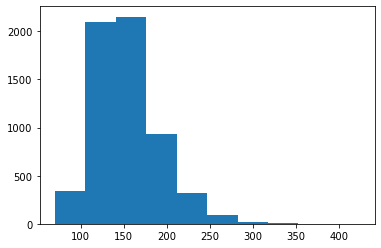

In [7]:
# sorted so each row is in strictly increasing order
edm_sort = edm.sort(axis=1)
# print histogram of k^{th} lowest distance for each point
k = 12
# get kth largest distance from each object
edm_kthlargest = edm_sort.values[:,k]
plt.hist(edm_kthlargest.cpu().detach().numpy())

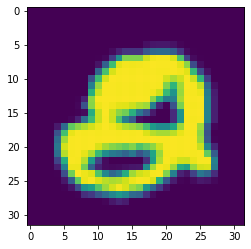

In [8]:
# print datapoints with maximal minimum distance
max_kdist_arg = torch.argmax(edm_sort.values[:,k])
ind_i = max_kdist_arg
ind_j = edm_sort.indices[max_kdist_arg, k]
plt.imshow(Z[:,ind_i].detach().cpu().numpy().reshape(32,32))


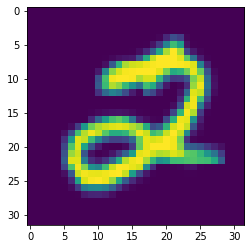

In [9]:
plt.imshow(Z[:,ind_j].detach().cpu().numpy().reshape(32,32))

Create $k$-NN graph to search for geodesics between arbitrary data points

In [28]:
k = 12
source = 0
print('building knn graph...')
knn_graph = sklearn.neighbors.kneighbors_graph(Z.cpu().detach().numpy().T, k, mode='distance')
print('computing min-dist search from source')
# compute approximate geodesic distances (g_dist) and predecessors for geodesic
# (g_predecessor) from Z[:,source]
g_dist, g_predecessor = scipy.sparse.csgraph.shortest_path(knn_graph, directed=False, indices=source, return_predecessors=True)
print('done!')


building knn graph...
computing min-dist search from source
done!


In [33]:
# build geodesic from source to dest
dest = 2
g_list = Z[:,[dest]].clone()
# track where we currently are in the geodesic
curr_pos = dest
while curr_pos != source:
	curr_pos = g_predecessor[curr_pos]
	g_list = torch.hstack((Z[:,[curr_pos]], g_list))

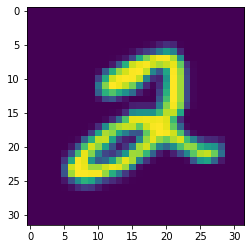

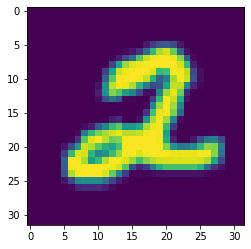

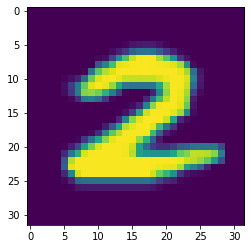

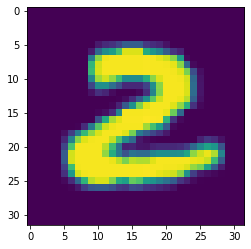

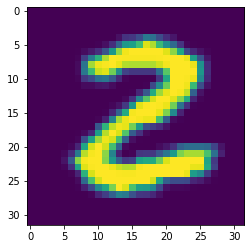

In [34]:
for i in range(g_list.shape[1]):
	plt.imshow(g_list[:,i].detach().cpu().numpy().reshape(32,32))
	plt.show()
	

# testing full linearization

In [8]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

	def __init__(self, X, u_0):
		super(CurvatureElimination, self).__init__();
		# data
		self.X = X
		# construct edm and gamma weight matrix
		gram = X.T@X
		edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
				+ torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
				- 2*gram

		# diagonal weights don't matter, set to 1 as convention
		self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
		# projection vec
		self.u = nn.Parameter(u_0)

	def forward(self):
		U_stacked = torch.ones(self.X.shape)*self.u
		A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
		return 0.5*A.pow(4).sum()

In [35]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())

U, S, V = torch.svd(Z - Z.mean(axis=1, keepdim=True))

# truncate machine-precision principal components
S_r = torch.diag(S)
r = S_r.shape[0]
U_r = U[:,:r]
V_r = V[:,:r]
Z_r = U_r @ S_r @ V_r.T

X = Z.clone()

cc = CurvatureElimination(X, u_0)
opt = optim.SGD(cc.parameters(), lr=100)

for i in range(100):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%10 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

dist: 3.248880275918964e-08
g step 0: 0.008192386478185654
g step 10: 0.4594199061393738
g step 20: 0.032339584082365036


KeyboardInterrupt: 